Consider an axisymmetric top, rotating about a fixed point on its axis of symmetry. By choosing units such that $mgh = A$, the Lagrangian scaled by $A$ is
\begin{equation}
L = \frac{1}{2}[\dot\theta^2 + \dot\phi^22\sin^2\theta] + \frac{1}{2}C[\dot\psi + \dot\phi\cos θ]^2 - \cos\theta.
\end{equation}
Here, $\theta, \phi, \psi$ are the usual three Eulerian angles and $C$ is the ratio of the principal moments of inertia (in usual, dimensional, notation, equal to $C/A$). The first Lagrangian equation of motion is then
\begin{equation}
0 = \frac{d}{dt}\left(\frac{\partial L}{\partial \dot\theta}\right) - \frac{\partial L}{\partial \theta} = \ddot\theta - \dot\phi^2\sin\theta\cos\theta + C\dot\phi\sin\theta [\dot\psi + \dot\phi\cos\theta] - \sin θ.
\end{equation}
The other two can immediately be integrated once to give
\begin{align}
\frac{\partial L}{\partial \ddot\psi} = \text{constant} &\implies C[\dot\psi + \dot\phi\cos\theta] = \alpha, \\
\frac{\partial L}{\partial \dot\phi} = \text{constant} &\implies \alpha\cos\theta + \dot\phi\sin^2\theta = \beta.
\end{align}
The energy integral is
\begin{equation}
E = \frac{1}{2}[\dot\theta^2 + \dot\phi^2\sin^2\theta] + \frac{1}{2}C[\dot\psi + \dot\phi\cos\theta]^2 + \cos\theta = \text{constant}.
\end{equation}
The equations can be rewritten in a form suitable for numerical solution as
\begin{align}
    \dot\phi &= \frac{\beta − \alpha\cos\theta}{\sin^2\theta}, \\
    \ddot\theta &= [\dot\phi(\dot\phi\cos\theta − \alpha) + 1]\sin\theta.
\end{align}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, OdeSolution
import textwrap

def axisymmetric_top_odes(t, y, C, alpha, beta):
    '''
    Defines the system of ordinary differential equations for the axisymmetric top.
    '''
    theta, omega = y[0], y[1]
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)

    # Handle the singularity when sin(theta) is close to zero to prevent division by zero.
    epsilon = 1e-9
    if abs(sin_theta) < epsilon:
        sin_theta = np.sign(sin_theta) * epsilon if sin_theta != 0 else epsilon

    sin_theta_sq = sin_theta**2
    # Equation (4) for the rate of precession (phi_dot)
    phi_dot = (beta - alpha * cos_theta) / sin_theta_sq
    # Equation (5) for the second derivative of nutation (theta_ddot or omega_dot)
    omega_dot = (phi_dot * (phi_dot * cos_theta - alpha) + 1) * sin_theta
    # Derived from Equation (1) for the rate of spin (psi_dot)
    psi_dot = (alpha / C) - (phi_dot * cos_theta)
    # The first element of the state vector derivative is omega (defined as theta_dot)
    theta_dot = omega

    return [theta_dot, omega_dot, phi_dot, psi_dot]

def calculate_constants(C, theta0, phi_dot0, psi_dot0):
    '''
    Calculates the conserved quantities, alpha and beta, from initial conditions.
    '''
    cos_theta0 = np.cos(theta0)
    sin_theta0_sq = np.sin(theta0)**2

    alpha = C * (psi_dot0 + phi_dot0 * cos_theta0)
    beta = alpha * cos_theta0 + phi_dot0 * sin_theta0_sq
    return alpha, beta

def run_simulation(C, y0, t_span, t_eval, alpha, beta):
    '''
    Runs the numerical simulation by solving the system of ODEs.
    '''
    solution = solve_ivp(
        fun=axisymmetric_top_odes,
        t_span=t_span,
        y0=y0,
        args=(C, alpha, beta),
        t_eval=t_eval,
        method='RK45'
    )
    return solution

def calculate_energy_and_derivatives(solution, C, alpha, beta):
    '''
    Post-processes the simulation results to calculate angular velocities and total energy.
    '''
    # Extract state variables from the solution
    theta, omega, _, _ = solution.y

    # Recalculate angular velocities (phi_dot, psi_dot) at each time step
    derivatives = np.array([axisymmetric_top_odes(t, y, C, alpha, beta)
                            for t, y in zip(solution.t, solution.y.T)])
    phi_dot = derivatives[:, 2]
    psi_dot = derivatives[:, 3]

    # Calculate total energy E using the formula from the problem description:
    # E = 1/2*(theta_dot^2 + phi_dot^2*sin(theta)^2) + 1/2*C*(psi_dot + phi_dot*cos(theta))^2 + cos(theta)
    energy = (0.5 * (omega**2 + phi_dot**2 * np.sin(theta)**2) +
              0.5 * C_val * (psi_dot + phi_dot * np.cos(theta))**2 +
              np.cos(theta))
    return energy

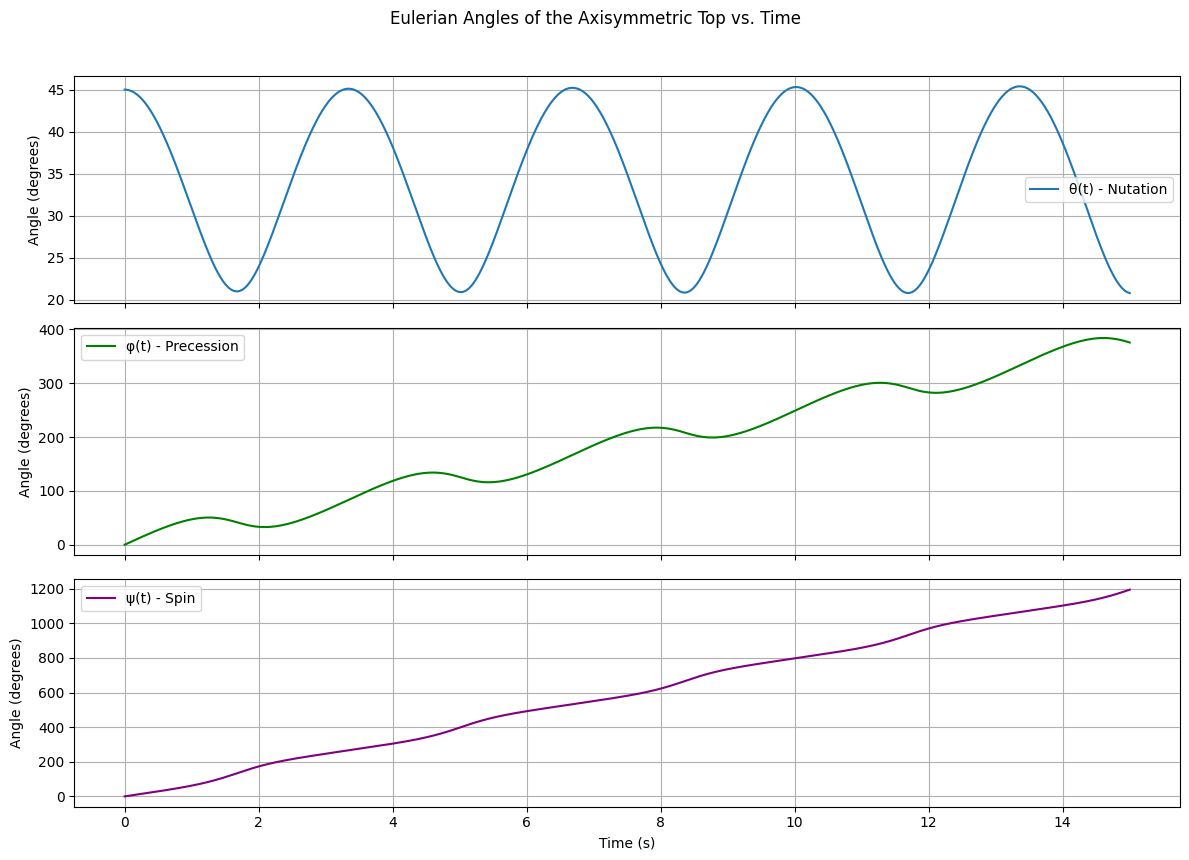

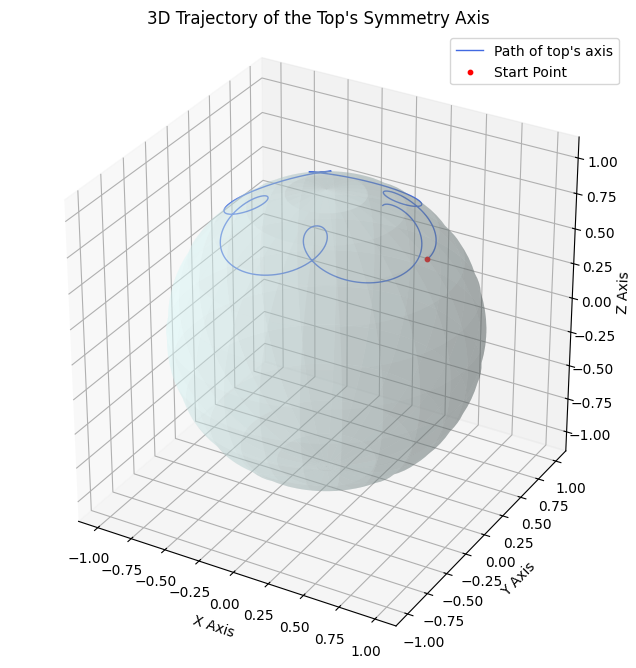

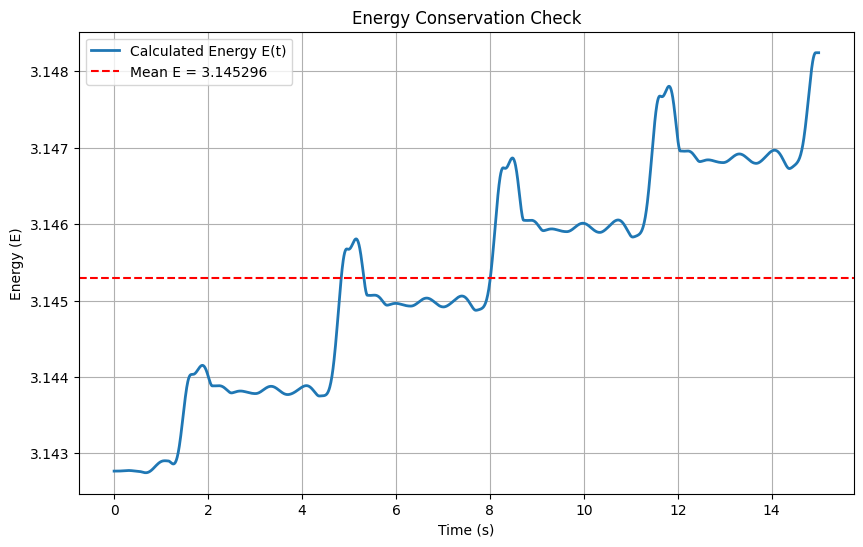


--- Energy Conservation ---
  Mean Energy: 3.14529560
  Standard Deviation: 1.414e-03
  Max Variation from Mean: 2.949e-03
-----------------------------------


In [2]:
def plot_eulerian_angles(solution):
    '''
    Plots the three Eulerian angles (theta, phi, psi) as a function of time.
    '''
    t, (theta, _, phi, psi) = solution.t, solution.y
    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
    fig.suptitle('Eulerian Angles of the Axisymmetric Top vs. Time')

    axes[0].plot(t, np.rad2deg(theta), label='θ(t) - Nutation')
    axes[0].set_ylabel('Angle (degrees)')
    axes[0].legend()

    axes[1].plot(t, np.rad2deg(phi), label='φ(t) - Precession', color='green')
    axes[1].set_ylabel('Angle (degrees)')
    axes[1].legend()

    axes[2].plot(t, np.rad2deg(psi), label='ψ(t) - Spin', color='purple')
    axes[2].set_ylabel('Angle (degrees)')
    axes[2].set_xlabel('Time (s)')
    axes[2].legend()

    for ax in axes:
        ax.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

def plot_3d_trajectory(solution):
    '''
    Creates a 3D plot showing the trajectory of the top's symmetry axis on a unit sphere.
    '''
    theta, _, phi, _ = solution.y

    # Convert spherical coordinates to Cartesian for plotting the axis tip
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the trajectory
    ax.plot(x, y, z, label="Path of top's axis", color='royalblue', linewidth=1)
    ax.scatter(x[0], y[0], z[0], color='red', s=10, label='Start Point', zorder=5)

    # Create a wireframe for the unit sphere for context
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 50)
    sphere_x = np.outer(np.cos(u), np.sin(v))
    sphere_y = np.outer(np.sin(u), np.sin(v))
    sphere_z = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_surface(sphere_x, sphere_y, sphere_z, color='lightcyan', rstride=4, cstride=4, alpha=0.3)

    ax.set_xlabel('X Axis'); ax.set_ylabel('Y Axis'); ax.set_zlabel('Z Axis')
    ax.set_title("3D Trajectory of the Top's Symmetry Axis")
    ax.set_box_aspect([1, 1, 1])
    ax.legend()
    plt.show()

def plot_energy_conservation(t, E):
    '''
    Plots the calculated energy over time to verify its conservation.
    '''
    plt.figure(figsize=(10, 6))
    plt.plot(t, E, label='Calculated Energy E(t)', linewidth=2)
    plt.title('Energy Conservation Check')
    plt.xlabel('Time (s)')
    plt.ylabel('Energy (E)')
    plt.grid(True)

    E_mean = np.mean(E)
    plt.axhline(E_mean, color='r', linestyle='--', label=f'Mean E = {E_mean:.6f}')
    plt.legend()
    plt.show()

    E_std = np.std(E)
    max_variation = np.max(np.abs(E - E_mean))
    print("\n--- Energy Conservation ---")
    print(f"  Mean Energy: {E_mean:.8f}")
    print(f"  Standard Deviation: {E_std:.3e}")
    print(f"  Max Variation from Mean: {max_variation:.3e}")
    print("-" * 35)

# Set physical parameters and initial conditions
C_val = 1.5  # Ratio of moments of inertia (I_3 / I_1)

# Initial angles and angular velocities (in degrees and rad/s for clarity)
theta_0_deg = 45.0
omega_0_rad_s = 0.0  # Initial "kick" in the theta direction
phi_dot_0_rad_s = 1.0  # Initial precession rate
psi_dot_0_rad_s = 1.0 # Initial spin rate

# Convert to radians
theta_0_rad = np.deg2rad(theta_0_deg)
phi_0_rad = 0.0  # Initial precession and spin angles can be 0
psi_0_rad = 0.0

# Set simulation parameters
simulation_time = 15.0  # seconds
num_points = 2000
t_span = [0, simulation_time]
t_eval = np.linspace(t_span[0], t_span[1], num_points)

# Prepare and run the simulation
alpha_val, beta_val = calculate_constants(C_val, theta_0_rad, phi_dot_0_rad_s, psi_dot_0_rad_s)
initial_conditions = [theta_0_rad, omega_0_rad_s, phi_0_rad, psi_0_rad]
simulation_result = run_simulation(C_val, initial_conditions, t_span, t_eval, alpha_val, beta_val)

# Process results and generate outputs
if simulation_result.success:
    plot_eulerian_angles(simulation_result)
    plot_3d_trajectory(simulation_result)
    energy_over_time = calculate_energy_and_derivatives(simulation_result, C_val, alpha_val, beta_val)
    plot_energy_conservation(simulation_result.t, energy_over_time)
else:
    print("\nERROR: The ODE solver failed to find a solution.")
    print(f"Solver message: {simulation_result.message}")

The numerical method chosen is an explicit Runge-Kutta method of order 4 with error estimator of order 5 known as the Dormand-Prince method. Its key feature is adaptive step-sizing, where it automatically adjusts the integration step size to maintain a specified error tolerance. This makes it both efficient and accurate. It takes small steps when the top's motion is complex and larger steps when the motion is smooth.

A way to verify the program's accuracy is to check for the conservation of energy. For a conservative physical system like a spinning top with no friction, the total energy should remain constant over time. The small variation from the mean are attributable to the finite precision of floating-point arithmetic and the truncation error of the numerical method, confirming that the simulation is stable and accurate.

A numerical issue arises when the nutation angle $\theta$ is close to 0 or $\pi$, when the top is nearly vertical. The equation for the precession rate is $\dot\phi = (\beta - \alpha\cos\theta) / \sin^2\theta$, so as $\theta$ approaches $0$ or $\pi$, then $\dot\phi$ diverges, which can lead to a division-by-zero error, floating-point overflow, or extreme numerical instability. This is resolved by adding a small epsilon value.

The nutation angle $\theta$ is physically defined to be within the range $[0, \pi]$, where $\theta = 0$ is straight up and $\theta = \pi$ is straight down. If the numerical solution for $\theta$ leaves this domain, it does not represent an impossible physical state but rather a known artifact of the Euler angle coordinate system. The physical orientation can be mapped back to the proper range:
*   If $\theta$ becomes negative, then this is physically equivalent to a positive nutation angle of $\delta$, but with a simultaneous rotation of the precession angle $\phi$ by $\pi$. This corresponds to the top's axis crossing the north pole and emerging on the other side.
*   If $\theta$ becomes greater than $\pi$, then this is physically equivalent to a nutation angle of $\pi - \delta$, again coupled with a change in the precession angle $\phi$ by $\pi$, corresponding to the axis crossing the south pole.

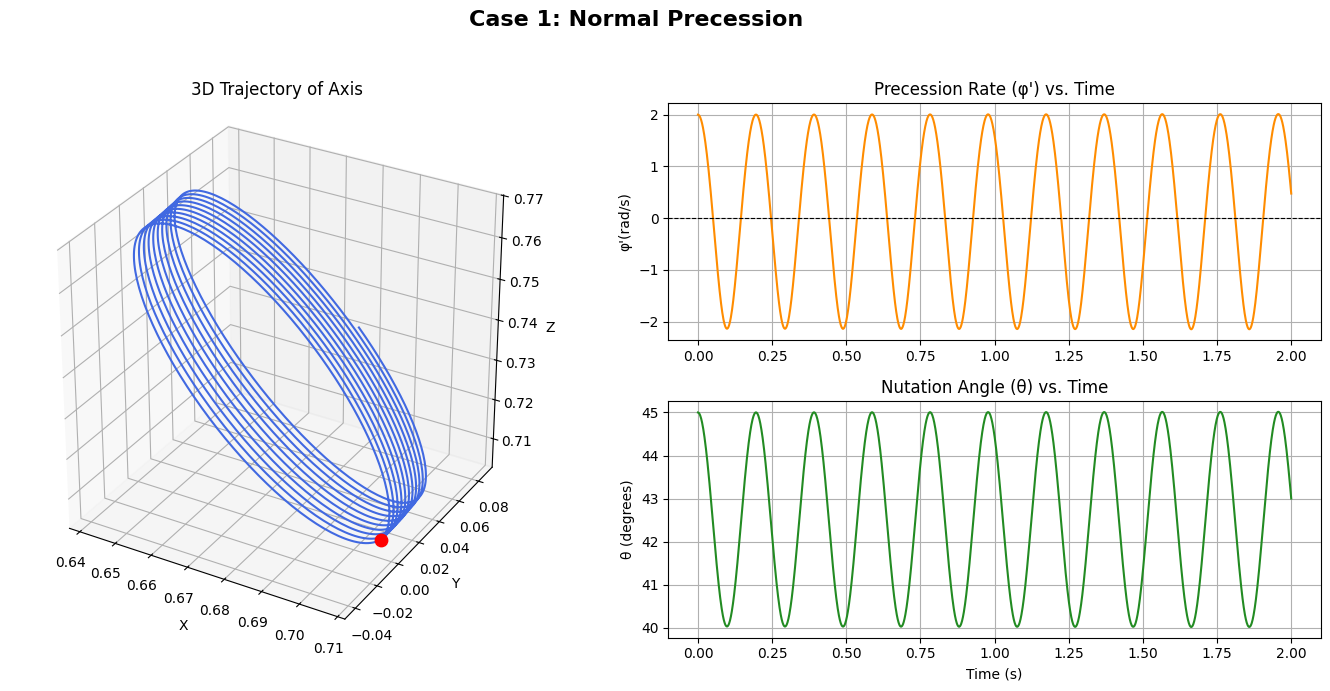

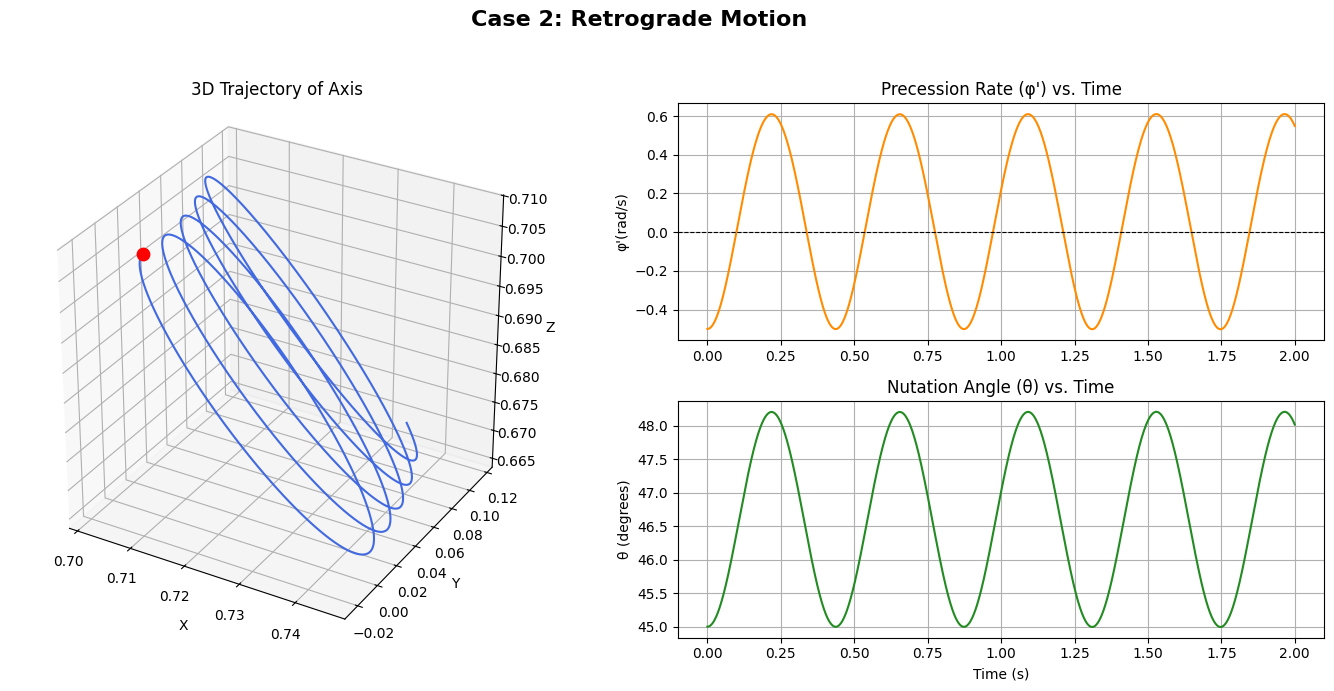

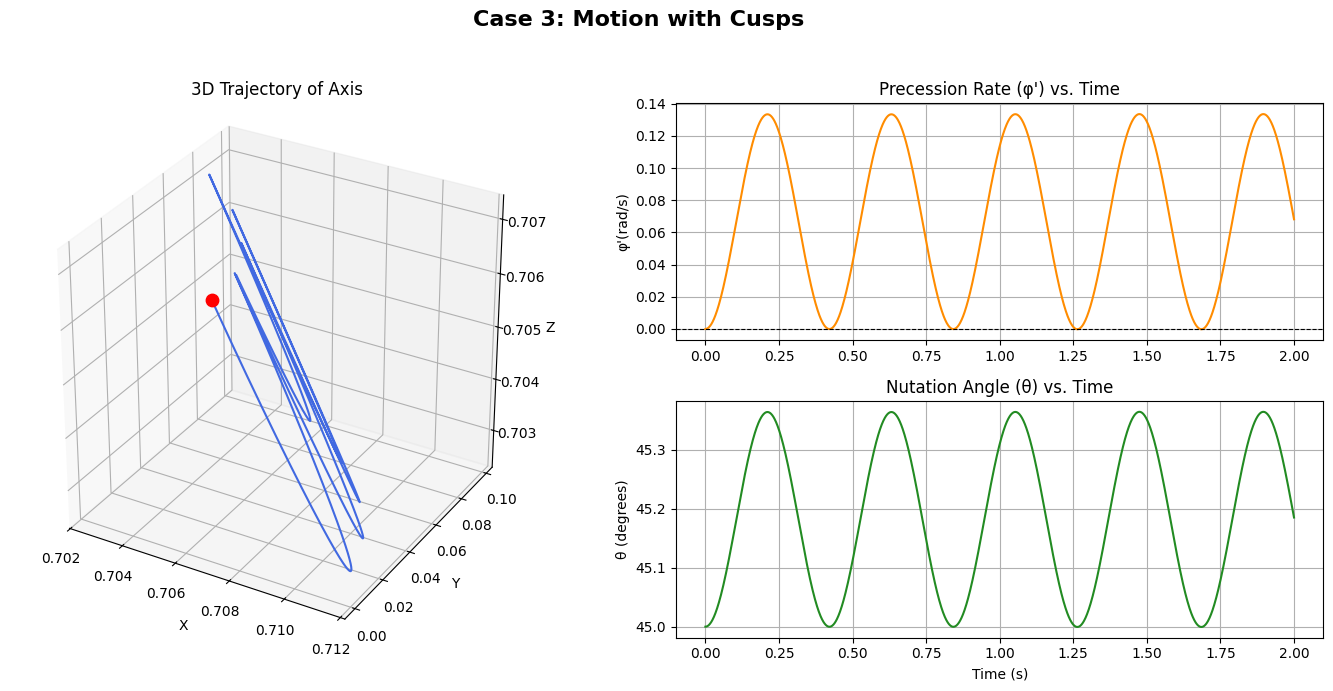

In [3]:
def plot_motion_case(solution, title):
    '''
    Generates a comprehensive set of plots for a given simulation case.
    This includes the 3D trajectory, precession rate (phi_dot), and nutation (theta).
    '''
    # Extract data
    t = solution.t
    theta, omega, phi, psi = solution.y
    C, alpha, beta = solution.args

    # Calculate phi_dot
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    epsilon = 1e-9
    sin_theta_sq = np.where(np.abs(sin_theta) < epsilon, epsilon**2, sin_theta**2)
    phi_dot = (beta - alpha * cos_theta) / sin_theta_sq

    # Create plots
    fig = plt.figure(figsize=(14, 7))
    fig.suptitle(title, fontsize=16, weight='bold')

    # 3D Trajectory Plot
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    ax1.plot(x, y, z, label="Path of top's axis", color='royalblue')
    ax1.scatter(x[0], y[0], z[0], color='red', s=80, label='Start')
    ax1.set_title("3D Trajectory of Axis")
    ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
    ax1.set_box_aspect([1, 1, 1])

    # Precession Rate (phi_dot) vs. Time
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(t, phi_dot, color='darkorange')
    ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax2.set_title("Precession Rate (φ') vs. Time")
    ax2.set_ylabel("φ'(rad/s)")
    ax2.grid(True)

    # Nutation Angle (theta) vs. Time
    ax3 = fig.add_subplot(2, 2, 4)
    ax3.plot(t, np.rad2deg(theta), color='forestgreen')
    ax3.set_title("Nutation Angle (θ) vs. Time")
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("θ (degrees)")
    ax3.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

C_val = 1.5
t_span = [0, 2.0]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
theta_0_rad = np.deg2rad(45)
omega_0_rad_s = 0.0

# Normal precession (φ' does not change sign)
phi_dot_0 = 2.0
psi_dot_0 = 20.0
alpha, beta = calculate_constants(C_val, theta_0_rad, phi_dot_0, psi_dot_0)
y0 = [theta_0_rad, omega_0_rad_s, 0.0, 0.0]
solution = run_simulation(C_val, y0, t_span, t_eval, alpha, beta)
solution.args = (C_val, alpha, beta) # Store constants for plotting
plot_motion_case(solution, "Case 1: Normal Precession")

# Retrograde motion (φ' changes sign)
phi_dot_0 = -0.5
psi_dot_0 = 10.0
alpha, beta = calculate_constants(C_val, theta_0_rad, phi_dot_0, psi_dot_0)
y0 = [theta_0_rad, omega_0_rad_s, 0.0, 0.0]
solution = run_simulation(C_val, y0, t_span, t_eval, alpha, beta)
solution.args = (C_val, alpha, beta)
plot_motion_case(solution, "Case 2: Retrograde Motion")

# Motion with ,usps (border case)
phi_dot_0 = 0.0
psi_dot_0 = 10.0
alpha, beta = calculate_constants(C_val, theta_0_rad, phi_dot_0, psi_dot_0)
y0 = [theta_0_rad, omega_0_rad_s, 0.0, 0.0]
solution = run_simulation(C_val, y0, t_span, t_eval, alpha, beta)
solution.args = (C_val, alpha, beta)
plot_motion_case(solution, "Case 3: Motion with Cusps")

The motion of a rotating top is governed by the principles of conservation of energy and angular momentum.
1.  $C[\dot\psi + \dot\phi\cos\theta] = \alpha$.

    This represents the conservation of the angular momentum component along the top's symmetry axis (the $z$-axis in the body frame).

2.  $\alpha\cos\theta + \dot\phi\sin^2\theta = \beta$.
    
    This represents the conservation of the angular momentum component along the fixed, vertical $z$-axis of the laboratory frame.

3.  $E = \frac{1}{2}[\dot\theta^2 + \dot\phi^2\sin^2\theta] + \frac{1}{2}C[\dot\psi+ \dot\phi\cos\theta]^2 + \cos\theta$.
    
    This is the conservation of total energy, which is the sum of the kinetic energy of rotation and the potential energy due to gravity.

By substituting $\alpha$ and $\beta$ into the energy equation, we can eliminate $\dot\psi$ and $\dot\phi$ to find an equation solely for the nutation angle $\theta$ and its derivative $\dot\theta$. This leads to the concept of an effective potential, which we denote as $V_{\text{eff}}(\theta)$,
\begin{equation}
    E = \frac{1}{2}\dot\theta^2 + V_{\text{eff}}(\theta), \quad
    V_{\text{eff}}(\theta) = \frac{(\beta - \alpha\cos\theta)^2}{2\sin^2\theta} + \frac{\alpha^2}{2C} + \cos\theta.
\end{equation}

The motion in $\theta$ is confined to regions where $E \geq V_{\text{eff}}(\theta)$. The points where $E = V_{\text{eff}}(\theta)$ are the turning points of the nutation, where $\dot\theta = 0$. The top's axis oscillates between a minimum angle $\theta_{\min}$ and a maximum angle $\theta_{\max}$. The type of motion is determined by the behavior of the precession rate $\dot\phi$. Since $\theta$ oscillates between $\theta_{\min}$ and $\theta_{\max}$, the sign of $\dot\phi$ can either remain constant or change, leading to three distinct types of motion.
  
*   Normal precession is achieved when the top has a sufficiently high spin rate. The precession rate $\dot\phi$ remains positive throughout the motion as the term $(\beta - \alpha\cos\theta)$ never changes sign.
*   Retrograde motion occurs when the precession rate changes direction. This can be induced by giving the top a slower spin or a slight backward initial precession. The sign of $(\beta - \alpha\cos\theta)$ flips as $\theta$ oscillates between its turning points.
*   Motion with cusps is the critical border case where the precession rate becomes exactly zero at one of the turning points. The condition for this is $\dot\phi(\theta_0) = 0$, which implies $\beta = \alpha\cos(\theta_0)$. The path of the axis traces sharp cusps.